In [ ]:
!pip install keybert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 7.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk
from nltk.tokenize import sent_tokenize
import spacy
from textblob import TextBlob
from wordcloud import WordCloud
from gensim import corpora, models
from nltk.probability import FreqDist
import re
from nltk.stem import WordNetLemmatizer
from keybert import KeyBERT
from tqdm import tqdm
import multiprocessing as mp
import torch
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/dataset/news_articles.csv')
df2 = pd.read_csv('/content/drive/MyDrive/dataset/manually_coded.csv')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset/news_articles.csv')

In [ ]:
df_date = pd.read_csv('/content/drive/MyDrive/dataset/sample_news_articles 300.csv')['Date']

In [ ]:
df_date = pd.to_datetime(df_date, format='%d-%m-%Y')

In [ ]:
# Convert 'Date' column to datetime specifying the format
df['Date'] = df_date

In [ ]:
# Datetime conversion for the whole dataset
'''
# Specify the format for parsing dates
date_format = "%B %d, %Y %A"

# Function to parse date or return NaT for nonsensical values
def parse_date(date_str):
    try:
        return pd.to_datetime(date_str, format=date_format)
    except ValueError:
        return pd.NaT

# Apply the function to the 'Date' column
df['Date'] = df['Date'].apply(parse_date)
'''

In [ ]:
# Step 1: Extract the year from the 'Date' column
df['Year'] = df['Date'].dt.year

# Step 2: Group by the 'Year' and count the occurrences
year_counts = df.groupby('Year').size()

# Step 3: Calculate the percentage distribution
year_percentage = (year_counts / year_counts.sum()) * 100

# Step 4: Convert the result to a DataFrame for better readability
year_percentage_df = year_percentage.reset_index(name='Percentage')

In [ ]:
year_percentage_df

Year  Percentage
0   2010.0    1.116505
1   2011.0    2.392510
2   2012.0    3.335645
3   2013.0    3.814147
4   2014.0    4.084605
5   2015.0    5.839112
6   2016.0    8.855756
7   2017.0   11.074896
8   2018.0   13.058252
9   2019.0   14.729542
10  2020.0    9.008322
11  2021.0    6.990291
12  2022.0    5.839112
13  2023.0    8.522885
14  2024.0    1.338419

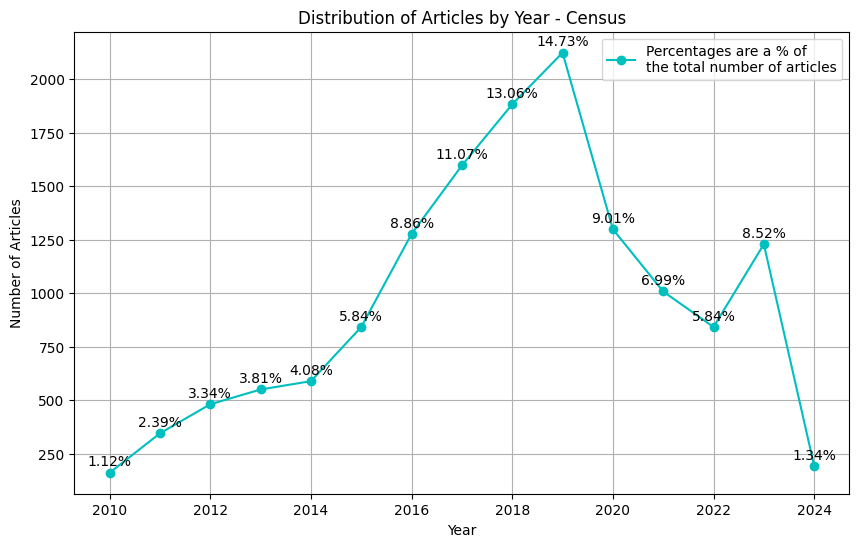

In [ ]:
# Ensure the 'Year' column is in integer format for plotting
year_percentage_df['Year'] = year_percentage_df['Year'].astype(int)

# Extract the counts of instances for each year
year_counts = df['Year'].value_counts().sort_index()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(year_counts.index, year_counts.values, marker='o', linestyle='-', color='c')

# Annotate each data point with the percentage value
for i in range(len(year_counts)):
    year = year_counts.index[i]
    count = year_counts.values[i]
    percentage = year_percentage_df[year_percentage_df['Year'] == year]['Percentage'].values[0]
    plt.annotate(f'{percentage:.2f}%', (year, count), textcoords="offset points", xytext=(0,5), ha='center')

# Set the labels and title
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles by Year - Census')
plt.legend(['Percentages are a % of\nthe total number of articles'], loc='upper right')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Define a function to count words in a string
def count_words(text):
    if pd.isna(text):
        return 0
    return len(text.split())

# Apply the function to the 'Body' column
df['WordCount'] = df['Body'].apply(count_words)

In [ ]:
# Create a distribution of the WordCount column
sns.histplot(df['WordCount'], kde=True)

# Calculate stats
mean = df['WordCount'].mean()
median = df['WordCount'].median()
std = df['WordCount'].std()

# Print the stats on the top right of the graph
plt.text(df['WordCount'].max() * 0.5, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean:.2f}', fontsize=12)
plt.text(df['WordCount'].max() * 0.5, plt.gca().get_ylim()[1] * 0.85, f'Median: {median:.2f}', fontsize=12)
plt.text(df['WordCount'].max() * 0.5, plt.gca().get_ylim()[1] * 0.8, f'Standard Deviation: {std:.2f}', fontsize=12)

# Show the plot
plt.show()

In [ ]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

In [ ]:
# Load the dataframe (assuming 'df' is already defined and has the 'Date' column)
df['Month'] = df['Date'].dt.month

# Group by year and month to count the number of articles per month per year
articles_per_year_month = df.groupby(['Year', 'Month']).size().reset_index(name='Count')

# Plot using FacetGrid
g = sns.FacetGrid(articles_per_year_month, col="Year", col_wrap=4, height=3, aspect=1.5)
g.map(sns.lineplot, "Month", "Count", marker="o")
g.set_axis_labels("Month", "Number of Articles")
g.set_titles("{col_name}")
g.set(xticks=range(1, 13), xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.tight_layout()
plt.show()


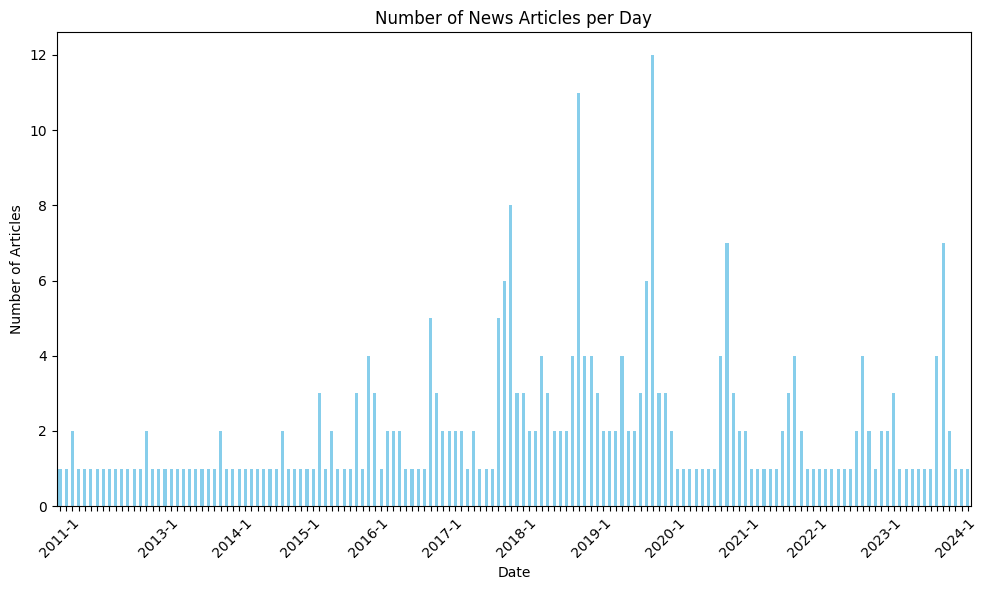

In [ ]:
# Group by year and month, and count the number of articles in each group
articles_per_month = df.groupby([df['Date'].dt.year, df['Date'].dt.month]).size()

# Plot the data
plt.figure(figsize=(10, 6))
articles_per_month.plot(kind='bar', color='skyblue')

# Set x-axis ticks to be labeled by years only
plt.xticks(range(len(articles_per_month.index)), [f"{year}-{month}" if month == 1 else "" for year, month in articles_per_month.index], rotation=45)

plt.title('Number of News Articles per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

In [ ]:
# Group by section for both dataframes
articles_per_section_df1 = df1.groupby(df1['Section']).size()
articles_per_section_df2 = df2.groupby(df2['Section']).size()

# Sort the data in descending order and select the top 20 locations for df1
top_20_locations_df1 = articles_per_section_df1.sort_values(ascending=False).head(20)

# Ensure df2 has the same sections as the top 20 from df1
top_20_locations_df2 = articles_per_section_df2.reindex(top_20_locations_df1.index).fillna(0)

# Calculate the total number of articles for both dataframes
total_articles_df1 = articles_per_section_df1.sum()
total_articles_df2 = articles_per_section_df2.sum()

# Calculate the percentage of the total for both dataframes
percentages_df1 = (top_20_locations_df1 / total_articles_df1) * 100
percentages_df2 = (top_20_locations_df2 / total_articles_df2) * 100

plt.style.use('tableau-colorblind10')

# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

indices = np.arange(len(top_20_locations_df1))
width = 0.35  # Width of the bars

# Bars for df1
bars_df1 = ax.bar(indices - width/2, percentages_df1, width, label='DataFrame 1', color='blue')

# Bars for df2
bars_df2 = ax.bar(indices + width/2, percentages_df2, width, label='DataFrame 2', color='green')

# Add text labels above the bars for df1
for bar, percentage in zip(bars_df1, percentages_df1):
    ax.text(bar.get_x()-.1 + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%',
            ha='center', va='bottom', fontsize=8, color='black', rotation = 45)

# Add text labels above the bars for df2
for bar, percentage in zip(bars_df2, percentages_df2):
    ax.text(bar.get_x()+.1 + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%',
            ha='center', va='bottom', fontsize=8, color='black', rotation = 45)
ax.text(16.5,15, "Percentages are a % of the\ntotal number of articles")

# Rotate x-axis labels by 45 degrees
ax.set_xticks(indices)
ax.set_xticklabels(top_20_locations_df1.index, rotation=45)

# Set titles and labels
ax.set_title('Top 20 Locations of Articles')
ax.set_xlabel('Location')
ax.set_ylabel('Percentage of Total Articles')

# Add legend
ax.legend(['Census', 'Sample'])

plt.tight_layout()
plt.show()


In [ ]:
print(plt.style.available)


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


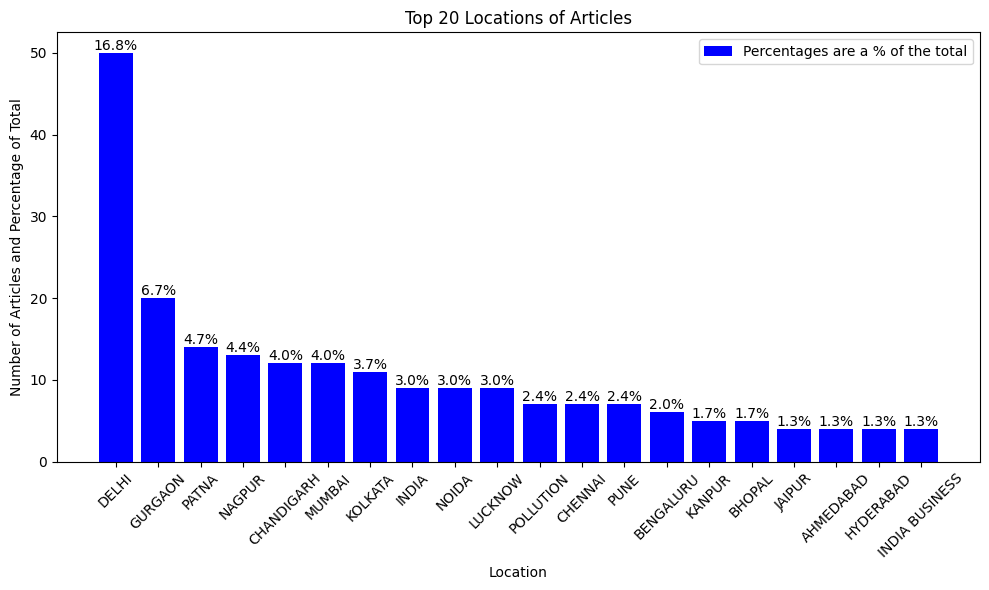

In [ ]:
# Group by section
articles_per_section = df.groupby(df['Section']).size()

# Sort the data in descending order and select the top 20 locations
top_20_locations = articles_per_section.sort_values(ascending=False).head(20)

# Calculate the percentage of the total
total_articles = articles_per_section.sum()
percentages = (top_20_locations / total_articles) * 100

# Plot the data
plt.figure(figsize=(10, 6))
bars = plt.bar(top_20_locations.index, top_20_locations.values, color='blue')

# Add text labels above the bars
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%',
             ha='center', va='bottom', fontsize=10, color='black')

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.title('Top 20 Locations of Articles')
plt.xlabel('Location')
plt.ylabel('Number of Articles and Percentage of Total')
plt.legend([bars], ['Percentages are a % of the total'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:

# Group by year and section to count the number of articles per location per year
articles_per_year_per_section = df.groupby(['Year', 'Section']).size().reset_index(name='Count')

# Get the top 10 locations based on total number of articles
top_10_locations = articles_per_year_per_section.groupby('Section')['Count'].sum().nlargest(10).index

# Plot the data for each top 10 location
plt.figure(figsize=(12, 8))

for location in top_10_locations:
    location_data = articles_per_year_per_section[articles_per_year_per_section['Section'] == location]
    plt.plot(location_data['Year'], location_data['Count'], marker='o')

plt.title('Top 10 Locations of Articles Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Articles')

# Set x ticks to every year from 2010 to 2024
plt.xticks(range(2010, 2025))

plt.legend(top_10_locations, title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
'''
df['Month'] = df['Date'].dt.month
# Get the range of years from the 'Year' column
years = df['Year'].unique()

# Group by year, month, and section to count the number of articles per location per month
articles_per_year_month_section = df.groupby(['Year', 'Month', 'Section']).size().reset_index(name='Count')

# Get the top 10 locations based on total number of articles
top_10_locations = articles_per_year_month_section.groupby('Section')['Count'].sum().nlargest(10).index

# Plot the data for each top 10 location for each year
for year in sorted(years):
    if pd.isnull(year):
        continue  # Skip NaN years

    plt.figure(figsize=(12, 8))
    for location in top_10_locations:
        location_data = articles_per_year_month_section[(articles_per_year_month_section['Year'] == year) & (articles_per_year_month_section['Section'] == location)]
        plt.plot(location_data['Month'], location_data['Count'], marker='o', label=location)

    plt.title(f'Top 10 Locations of Articles in {int(year)}')
    plt.xlabel('Month')
    plt.ylabel('Number of Articles')

    # Set x ticks to every month
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    '''

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Check if CUDA is available and set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize KeyBERT model and set it to use the GPU if available
kw_model = KeyBERT()
kw_model.model.embedding_model.to(device)

# Function to preprocess text
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower()
    text = text.strip()
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

# Function to extract topics
def extract_topics(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english')
    return [keyword[0] for keyword in keywords]

# Enable tqdm for pandas
tqdm.pandas()

# Preprocess the text data
df['Cleaned_Body'] = df['Body'].progress_apply(preprocess_text)

# Extract topics
df['Topics'] = df['Cleaned_Body'].progress_apply(extract_topics)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 22%|██▏       | 3280/14578 [07:31<25:56,  7.26it/s]


KeyboardInterrupt: 

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk import pos_tag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def tokenize(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    tagged = pos_tag(words)
    return [word for word, tag in tagged if tag.startswith(('NN', 'JJ'))]  # Keeping nouns and adjectives

# Apply tokenization
df1['filtered_tokens'] = df1['Body'].apply(tokenize)
df2['filtered_tokens'] = df2['Body'].apply(tokenize)

def get_frequency_distribution(tokens):
    all_tokens = [token for sublist in tokens for token in sublist]
    fdist = FreqDist(all_tokens)
    return fdist

# Get frequency distributions for both DataFrames
df1['frequency_distribution'] = df1['filtered_tokens'].apply(get_frequency_distribution)
df2['frequency_distribution'] = df2['filtered_tokens'].apply(get_frequency_distribution)

# Get total frequency distribution
all_words_df1 = df1['filtered_tokens'].explode()
all_words_df2 = df2['filtered_tokens'].explode()

fdist_total_df1 = FreqDist(all_words_df1)
fdist_total_df2 = FreqDist(all_words_df2)



In [ ]:
# Prepare data for plotting
common_words_df1 = fdist_total_df1.most_common(30)
words = [word for word, freq in common_words_df1]
frequencies_df1 = [freq for word, freq in common_words_df1]

# Frequencies for the second dataframe aligned to the words of the first dataframe
frequencies_df2 = [fdist_total_df2[word] if word in fdist_total_df2 else 0 for word in words]

# Calculate total frequencies
total_frequency_df1 = sum(frequencies_df1)
total_frequency_df2 = sum(frequencies_df2)

# Calculate percentages
percentages_df1 = [(freq / total_frequency_df1) * 100 for freq in frequencies_df1]
percentages_df2 = [(freq / total_frequency_df2) * 100 for freq in frequencies_df2]

# Plot the data
fig, ax = plt.subplots(figsize=(14, 7))

indices = np.arange(len(words))
width = 0.35  # Width of the bars

# Bars for dataset 1
bars_df1 = ax.bar(indices - width/2, percentages_df1, width, label='Dataset 1', color='blue')

# Bars for dataset 2
bars_df2 = ax.bar(indices + width/2, percentages_df2, width, label='Dataset 2', color='green')
# Add text labels above the bars for dataset 1
for bar, percentage in zip(bars_df1, percentages_df1):
    ax.text(bar.get_x() - 0.1 + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%',
            ha='center', va='bottom', fontsize=7, color='black', rotation=45)

# Add text labels above the bars for dataset 2
for bar, percentage in zip(bars_df2, percentages_df2):
    ax.text(bar.get_x() + 0.1 + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%',
            ha='center', va='bottom', fontsize=7, color='black', rotation=45)

ax.text(26,12.2, "Percentages are a % of the\ntotal number of words")


# Rotate words on x-axis to avoid overlap
ax.set_xticks(indices)
ax.set_xticklabels(words, rotation=90)

# Set titles and labels
ax.set_title('Top 30 Most Frequent Meaningful Words')
ax.set_xlabel('Words')
ax.set_ylabel('Percentage of Total Frequency')

# Add legend
ax.legend(["Census", "Sample"])

plt.tight_layout()
plt.show()


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def tokenize(text):
    words = word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    tagged = pos_tag(words)
    return [word for word, tag in tagged if tag.startswith(('NN', 'JJ'))]  # Keeping nouns and adjectives

df['filtered_tokens'] = df['Body'].apply(tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


NameError: name 'stopwords' is not defined

In [ ]:
'''
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def extract_entities(text):
    entities = []
    for sentence in sent_tokenize(text):
        # Tokenize and part-of-speech tagging
        words = nltk.word_tokenize(sentence)
        tagged_words = pos_tag(words)

        # Named entity recognition
        tree = ne_chunk(tagged_words)

        for subtree in tree:
            if type(subtree) == nltk.tree.Tree:  # Checking if it's a named entity
                et = subtree.label()  # Entity type
                entity = " ".join([token for token, pos in subtree.leaves()])
                entities.append((entity, et))
    return entities

# Applying NER to each row in your DataFrame
df['named_entities'] = df['Body'].apply(extract_entities)
'''

In [ ]:
# Function to get frequency distribution
def get_frequency_distribution(tokens):
    # Flat list of all tokens
    all_tokens = [token for sublist in tokens for token in sublist]
    fdist = FreqDist(all_tokens)
    return fdist

# Applying the function to get frequency distribution for each row
df['frequency_distribution'] = df['filtered_tokens'].apply(get_frequency_distribution)


In [ ]:
# To see the most common words across the dataset
all_words = df['filtered_tokens'].explode()  # This flattens the list of tokens column-wise
fdist_total = FreqDist(all_words)
#print(fdist_total.most_common(30))  # Change the number to see more or less common words

In [ ]:
# Prepare data for plotting
common_words = fdist_total.most_common(30)
words = [word for word, freq in common_words]
frequencies = [freq for word, freq in common_words]

# Calculate the total frequency
total_frequency = sum(frequencies)

# Calculate the percentage of each word
percentages = [(freq / total_frequency) * 100 for freq in frequencies]

# Create a bar chart
plt.figure(figsize=(10, 5))
bars = plt.bar(words, frequencies, color='blue')

# Add text labels above the bars
for bar, percentage in zip(bars, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%',
             ha='center', va='bottom', fontsize=7, color='black')

# Rotate words on x-axis to avoid overlap
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Most Frequent Meaningful Words')
plt.tight_layout()

# Add legend
plt.legend([bars], ['Percentages are a % of the total'], loc='upper right')

plt.show()

In [ ]:
!python -m spacy download en_core_web_md  # Download the required model

from thinc.api import require_gpu
require_gpu()  # or require_gpu(0) to select a specific GPU

import spacy

# Load the spaCy model
nlp = spacy.load('en_core_web_md', disable=['parser', 'tagger'])

# Process texts in batches and as a stream
texts = df['Body'].tolist()
docs = nlp.pipe(texts, batch_size=50)
# Extract entities
def extract_entities(doc):
    return [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['ORG', 'GPE']]

# Extract entities and apply as before
df['entities'] = [extract_entities(doc) for doc in docs]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 17.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


Creating the Dictionary and Corpus for Topic Modelling

In [ ]:
# Grouping DataFrame by year
grouped = df.groupby('Year')

# Function to create a dictionary and corpus
def create_corpus(group):
    dictionary = corpora.Dictionary(group['filtered_tokens'])
    corpus = [dictionary.doc2bow(text) for text in group['filtered_tokens']]
    return corpus, dictionary

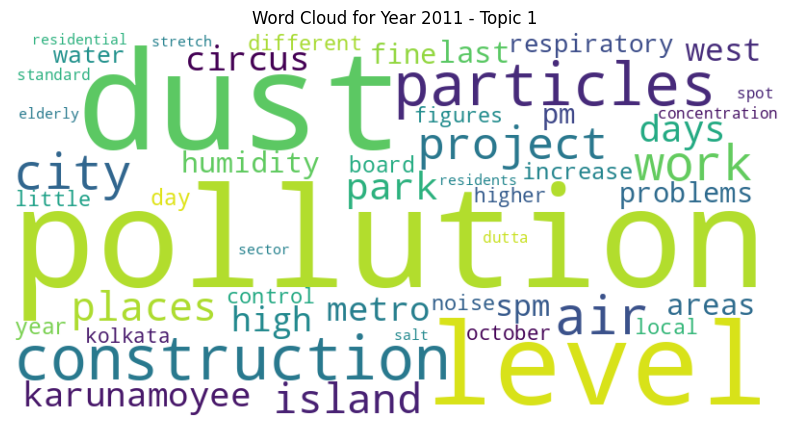

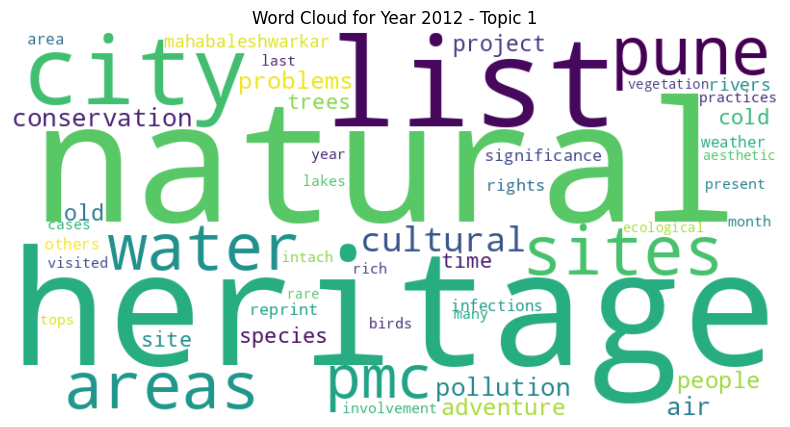

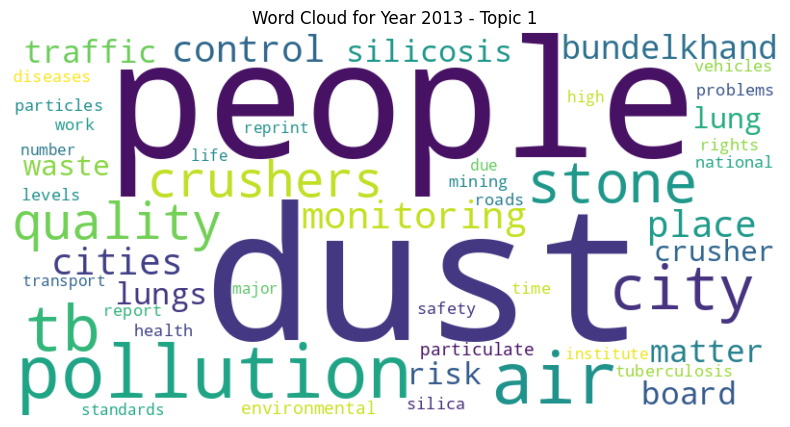

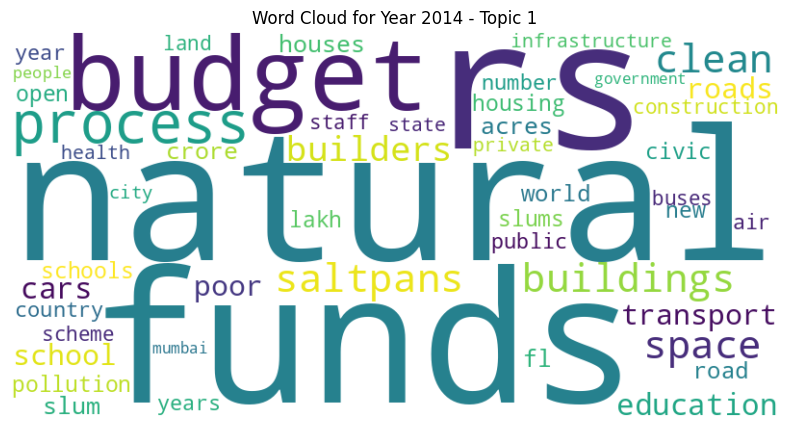

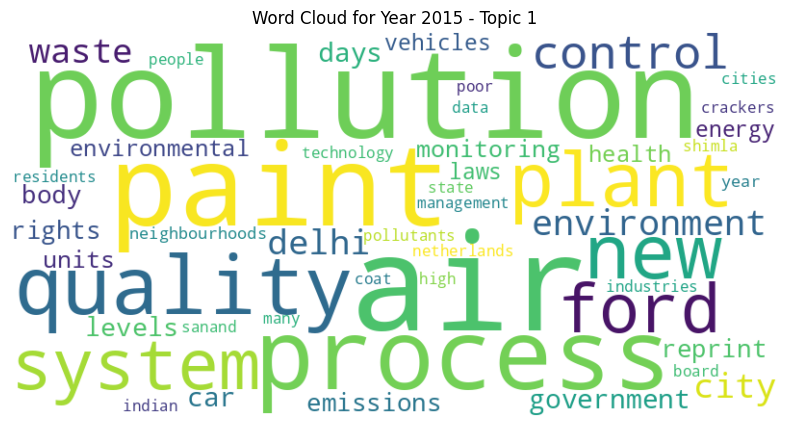

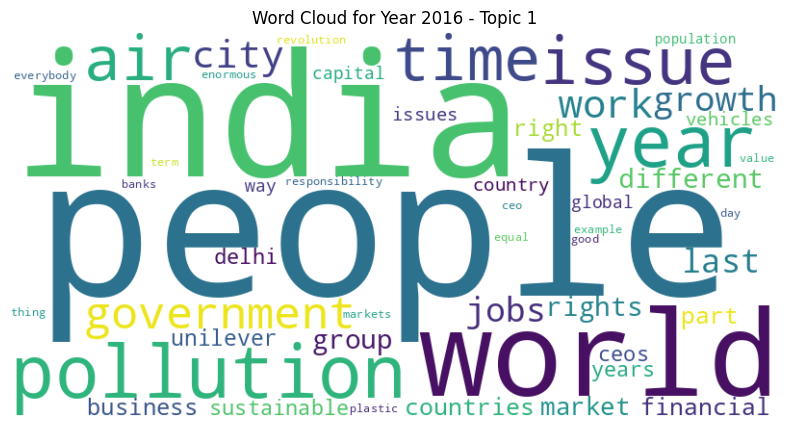

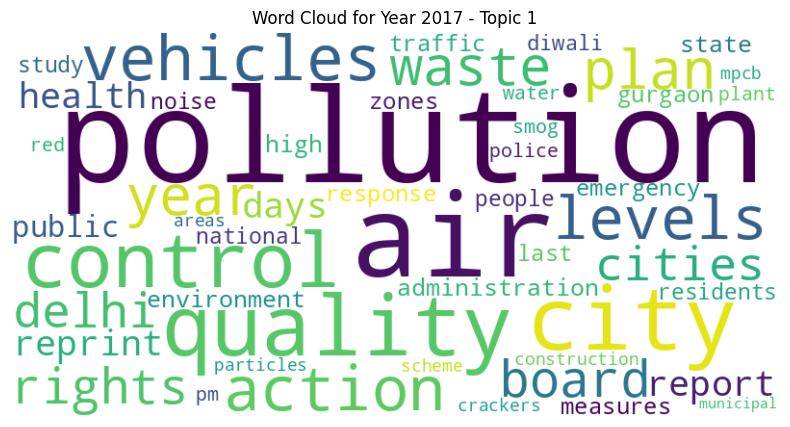

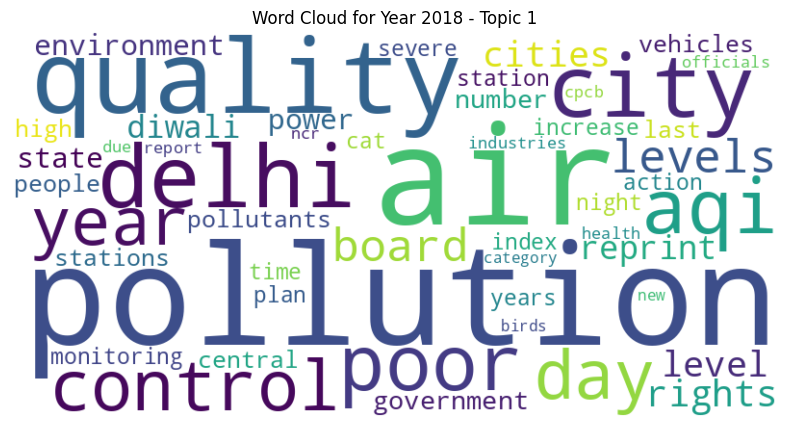

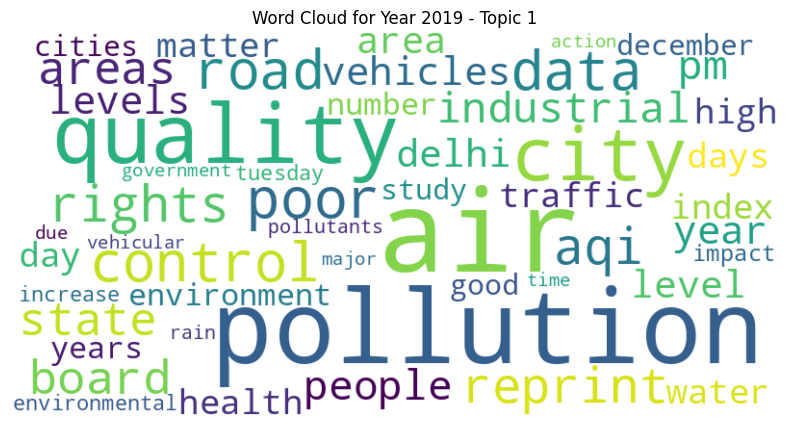

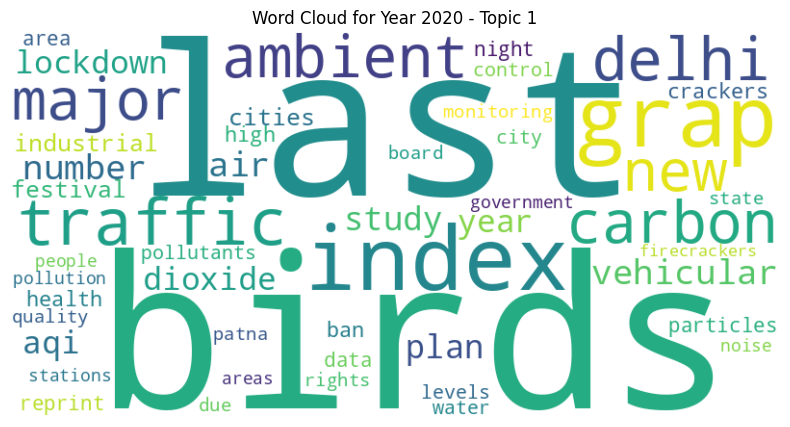

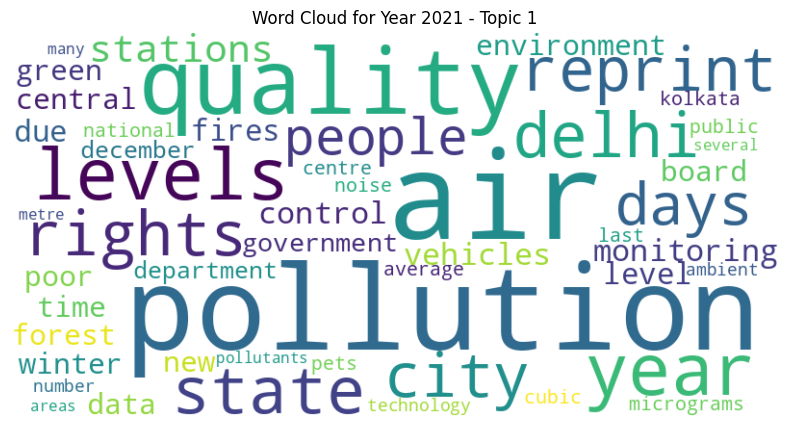

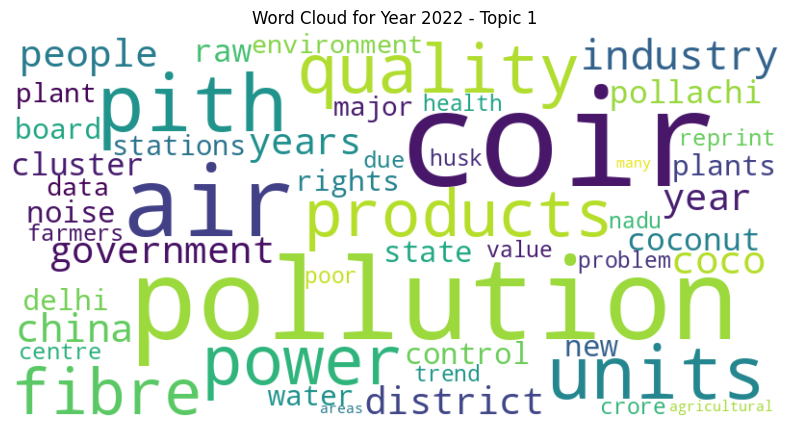

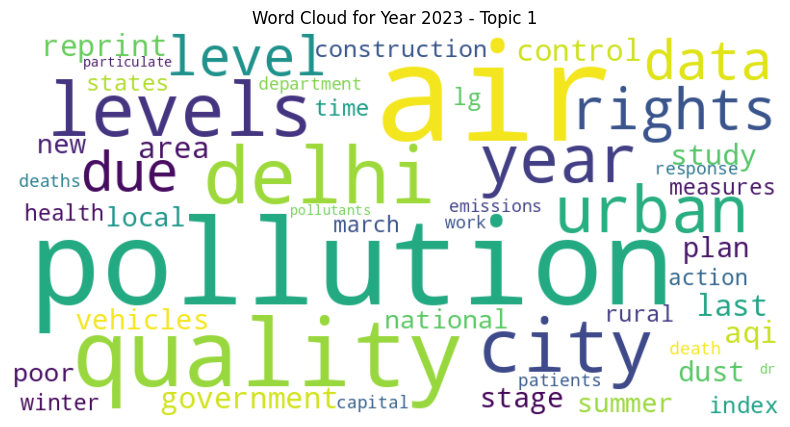

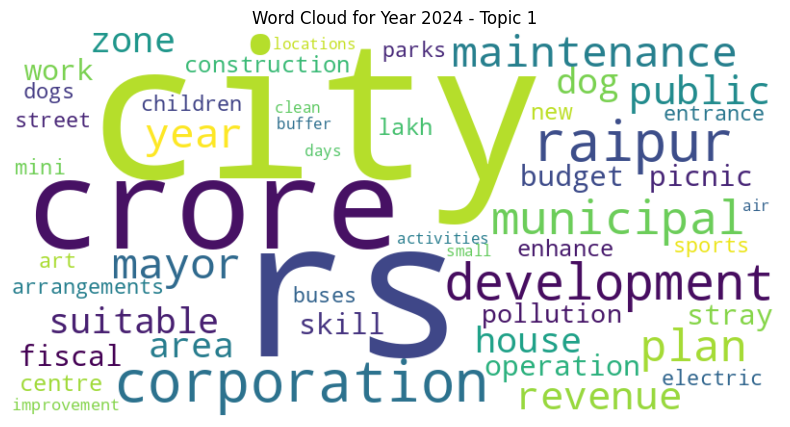

In [ ]:
# Iterate over each group, create LSI model and generate word clouds
for year, group in grouped:
    corpus, dictionary = create_corpus(group)
    lsi_model = models.LsiModel(corpus, id2word=dictionary, num_topics=1)  # Adjust the number of topics as necessary

    # Generate word cloud for each topic
    for i in range(lsi_model.num_topics):
        words = lsi_model.show_topic(i, topn=50)
        words_dict = dict(words)

        # Sort the words by frequency in ascending order
        words_sorted = dict(sorted(words_dict.items(), key=lambda item: item[1]))

        # Create WordCloud with all words horizontal
        wc = WordCloud(width=800, height=400, background_color='white', prefer_horizontal=1.0)
        wc.generate_from_frequencies(words_sorted)

        # Plot WordCloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.title(f'Word Cloud for Year {year} - Topic {i+1}')
        plt.axis("off")
        plt.show()

In [ ]:
for year, group in grouped:
    corpus, dictionary = create_corpus(group)
    lsi_model = models.LsiModel(corpus, id2word=dictionary, num_topics=10)  # Adjust the number of topics as necessary

    # Print words and weights for each topic
    for i in range(lsi_model.num_topics):
        print(f'Year: {year} - Topic {i+1}')
        words = lsi_model.show_topic(i, topn=50)

        # Print each word with its corresponding weight
        for word, weight in words:
            print(f"{word} {weight:.4f}")

        # Add a separator between topics for readability
        print("-" * 40)

Streaming output truncated to the last 5000 lines.
industrial -0.1996
area -0.1937
mia -0.1520
road 0.1518
pollution -0.1460
belt 0.1106
crackers 0.1080
january 0.1036
next -0.1034
jurisdiction -0.1031
levels 0.1027
limits -0.1024
council -0.1024
state -0.1022
august -0.1014
bench -0.1014
mpakvn -0.1014
notices -0.1014
plantation -0.1014
monsoon -0.1014
warrants -0.1014
extensive -0.1014
hearing -0.1014
panel -0.1012
plan -0.0982
member -0.0982
carry -0.0970
effect -0.0915
delhi 0.0781
noise 0.0716
parking 0.0699
cubic 0.0587
areas 0.0570
government -0.0568
metre 0.0566
housing -0.0558
central -0.0552
commercial 0.0549
world -0.0549
months -0.0517
connections -0.0517
impact -0.0512
current -0.0509
opinion -0.0509
expert -0.0509
----------------------------------------
Year: 2014 - Topic 9
levels 0.3447
january 0.3359
quality 0.2097
cities -0.2095
cubic 0.2036
metre 0.2021
air 0.1983
delhi 0.1925
critical 0.1527
micrograms 0.1527
poor 0.1496
india -0.1417
boundary 0.1339
north -0.1245
p

In [ ]:
# Creating a dictionary from the data
dictionary = corpora.Dictionary(df['filtered_tokens'])

# Creating a corpus from the dictionary
corpus = [dictionary.doc2bow(text) for text in df['filtered_tokens']]

In [ ]:
from gensim.models import LdaMulticore, CoherenceModel

# Assuming you already have 'dictionary' and 'corpus' prepared, and 'df['filtered_tokens']' is your tokenized data
texts = df['filtered_tokens']

# List to hold coherence values
coherence_values = []
model_list = []
topic_numbers = range(2, 15)  # Adjust this range according to your needs

for num_topics in topic_numbers:
    model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics, workers=2, passes=10, iterations=100)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Plotting coherence scores
plt.plot(topic_numbers, coherence_values)
plt.title('Coherence Scores by Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence score')
plt.show()


In [ ]:
lsi_model = models.LsiModel(corpus, id2word=dictionary, num_topics=5)  # You can adjust the number of topics

In [ ]:
# Parameters
num_topics = 5
passes = 10
iterations = 400

# Initialize LDA Model
lda_model = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         passes=passes,
                         iterations=iterations,
                         workers=4,  # Adjust based on your CPU
                         eval_every=1)  # Evaluate model convergence every pass


In [ ]:
# Print topics from LSI
print("LSI Model Topics:")
print(lsi_model.print_topics(num_words=5))

# Print topics from LDA
print("\nLDA Model Topics:")
print(lda_model.print_topics(num_words=5))

LSI Model Topics:
[(0, '0.504*"air" + 0.502*"pollution" + 0.228*"city" + 0.224*"quality" + 0.125*"levels"'), (1, '-0.348*"air" + 0.279*"city" + 0.278*"government" + 0.267*"people" + -0.206*"quality"'), (2, '0.417*"waste" + -0.345*"city" + 0.258*"pollution" + 0.229*"water" + -0.228*"quality"'), (3, '0.344*"people" + -0.263*"waste" + -0.251*"city" + -0.221*"vehicles" + 0.213*"india"'), (4, '-0.394*"pollution" + 0.390*"waste" + 0.328*"quality" + 0.267*"air" + -0.235*"noise"')]

LDA Model Topics:
[(0, '0.018*"waste" + 0.009*"pollution" + 0.008*"city" + 0.007*"stubble" + 0.007*"delhi"'), (1, '0.019*"pollution" + 0.015*"air" + 0.008*"vehicles" + 0.008*"city" + 0.006*"rights"'), (2, '0.010*"people" + 0.007*"city" + 0.005*"government" + 0.005*"pollution" + 0.005*"air"'), (3, '0.036*"air" + 0.030*"pollution" + 0.018*"quality" + 0.011*"city" + 0.009*"levels"'), (4, '0.014*"pollution" + 0.009*"air" + 0.009*"water" + 0.006*"city" + 0.006*"delhi"')]


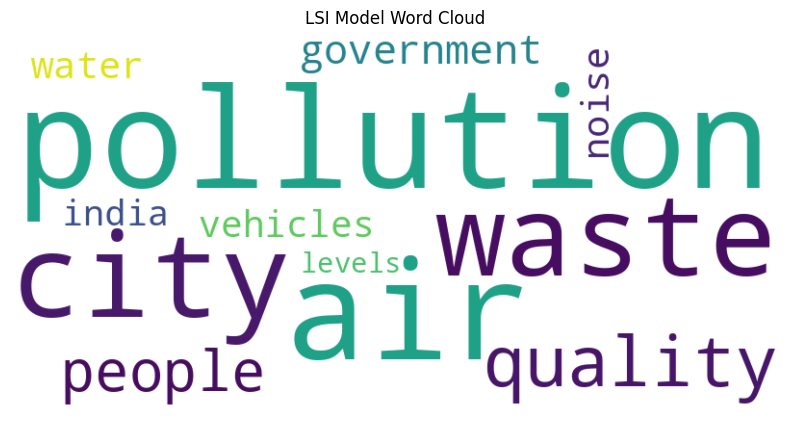

In [ ]:
from wordcloud import WordCloud

# Assuming lsi_model and lda_model are already trained model instances

# Extract topics directly into variables
lsi_topics = lsi_model.print_topics(num_words=5)
lda_topics = lda_model.print_topics(num_words=5)

# Function to parse topics and extract words and weights
def parse_topics(topics):
    word_frequencies = {}
    for _, topic in topics:
        for word_info in topic.split('+'):
            weight, word = word_info.split('*')
            weight = abs(float(weight.strip()))
            word = word.strip().strip('"')
            if word in word_frequencies:
                word_frequencies[word] += weight
            else:
                word_frequencies[word] = weight
    return word_frequencies

# Generate word frequencies for both models
lsi_word_frequencies = parse_topics(lsi_topics)
lda_word_frequencies = parse_topics(lda_topics)

# Generate word clouds
def generate_word_cloud(frequencies, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis("off")
    plt.show()

# Generate and display the word clouds
generate_word_cloud(lsi_word_frequencies, "LSI Model Word Cloud")
generate_word_cloud(lda_word_frequencies, "LDA Model Word Cloud")

In [ ]:
def plot_topic_barchart(topics):
    for index, (topic_number, words) in enumerate(topics):
        # Break down the topic into individual word-weight components
        word_info_list = words.split('+')
        words = []
        weights = []
        for word_info in word_info_list:
            weight, word = word_info.split('*')
            # Clean up the weight and word strings
            weight = weight.strip()
            word = word.strip().strip('"')
            # Convert weight to absolute float value
            try:
                weight = abs(float(weight))
            except ValueError:
                print(f"Error converting weight to float: {weight}")
                continue
            words.append(word)
            weights.append(weight)

        # Create a bar chart
        plt.figure(figsize=(10, 4))
        plt.bar(words, weights, color='blue')
        plt.xlabel('Words')
        plt.ylabel('Weights')
        plt.title(f'Topic #{topic_number}')
        plt.show()


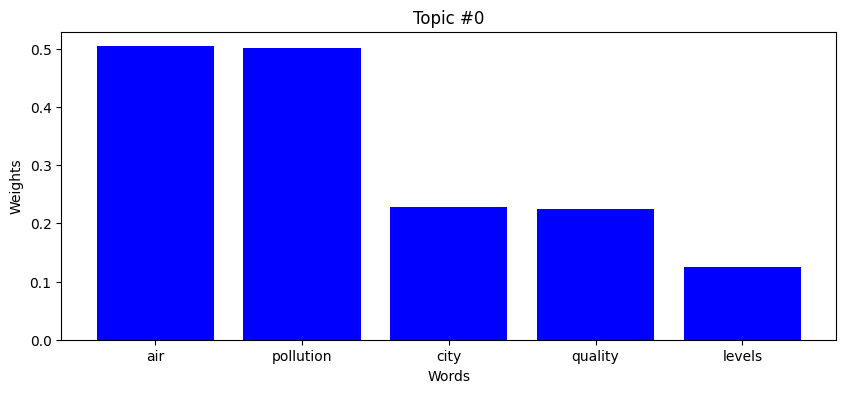

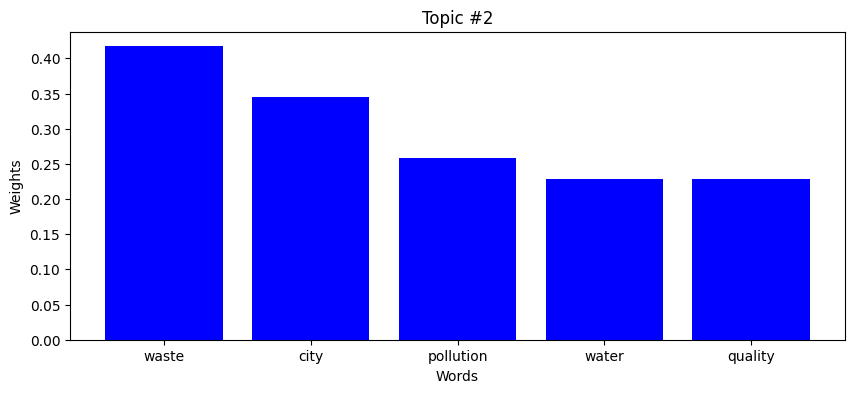

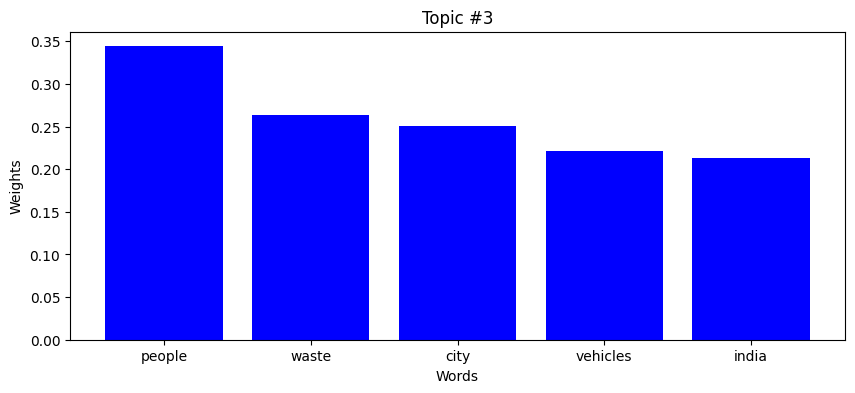

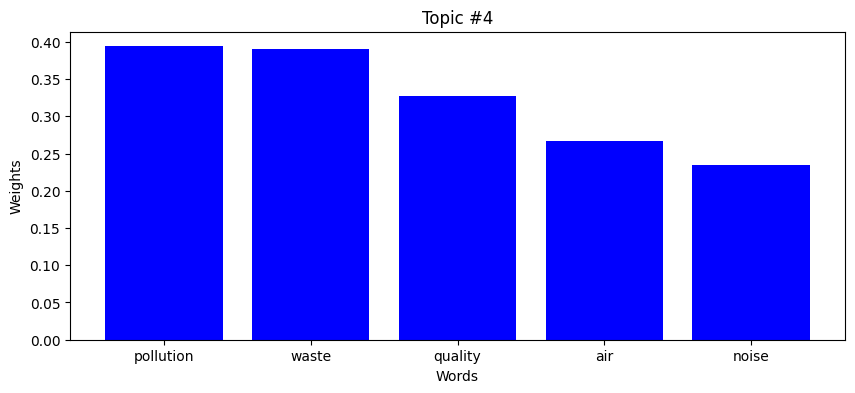

In [ ]:
# Example usage with LSI topics
plot_topic_barchart(lsi_model.print_topics(num_words=5))

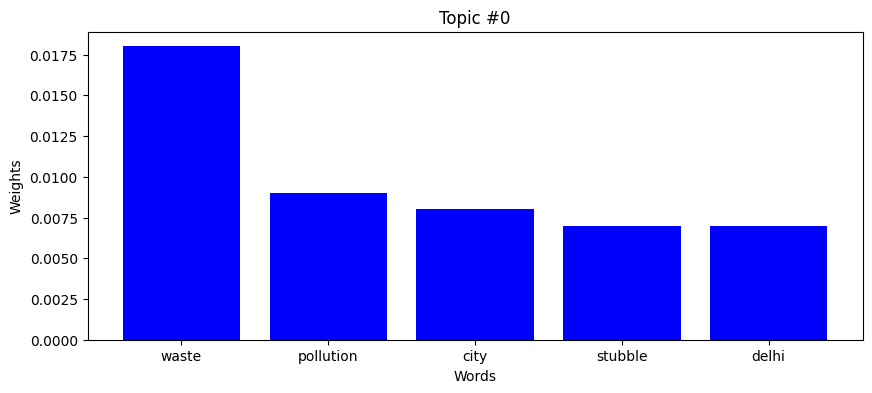

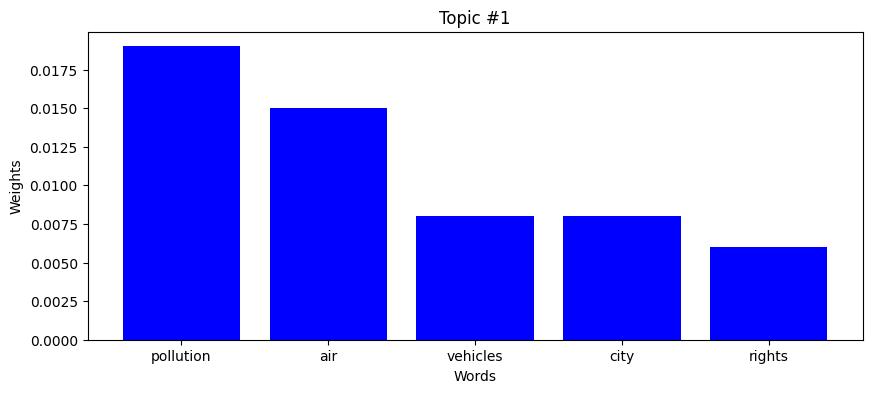

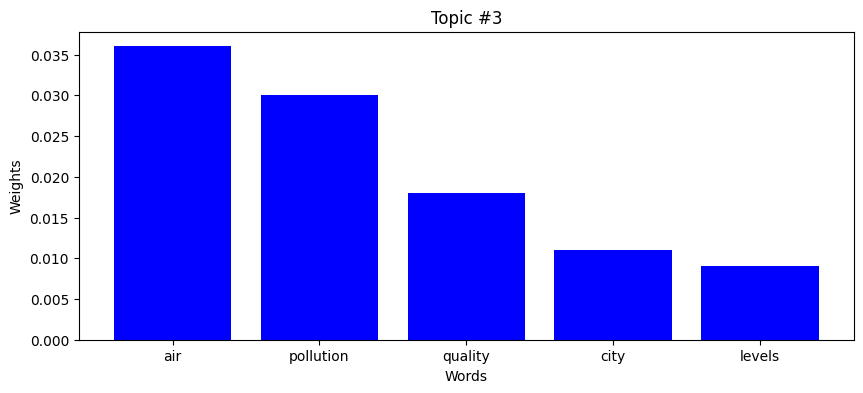

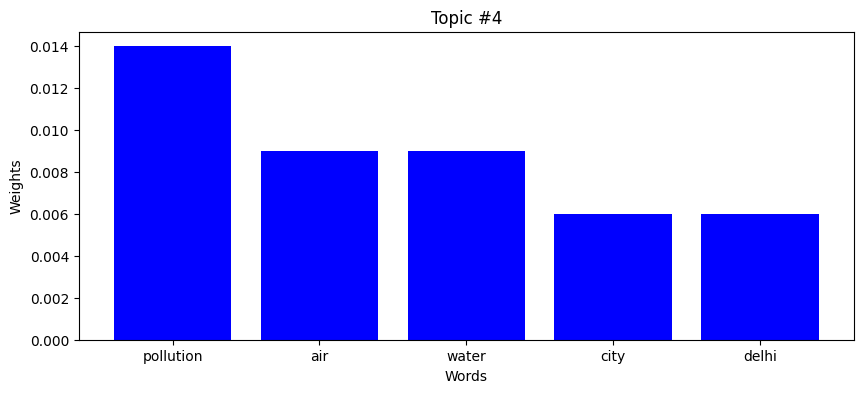

In [ ]:
# Example usage with LDA topics
plot_topic_barchart(lda_model.print_topics(num_words=5))

In [ ]:
import seaborn as sns
import numpy as np

def create_topic_word_matrix(topics):
    word_dict = {}
    for _, topic in topics:
        for word_info in topic.split('+'):
            weight, word = word_info.split('*')
            word = word.strip().strip('"')
            weight = float(weight)
            if word not in word_dict:
                word_dict[word] = []
            word_dict[word].append(weight)

    # Normalize lengths
    max_len = max(len(weights) for weights in word_dict.values())
    for weights in word_dict.values():
        while len(weights) < max_len:
            weights.append(0)

    # Create DataFrame
    df = pd.DataFrame(word_dict)
    df.index = [f'Topic {i+1}' for i in range(max_len)]
    return df

def plot_heatmap(df):
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.T, annot=True, cmap='viridis', cbar=True)
    plt.yticks(rotation=0)
    plt.show()

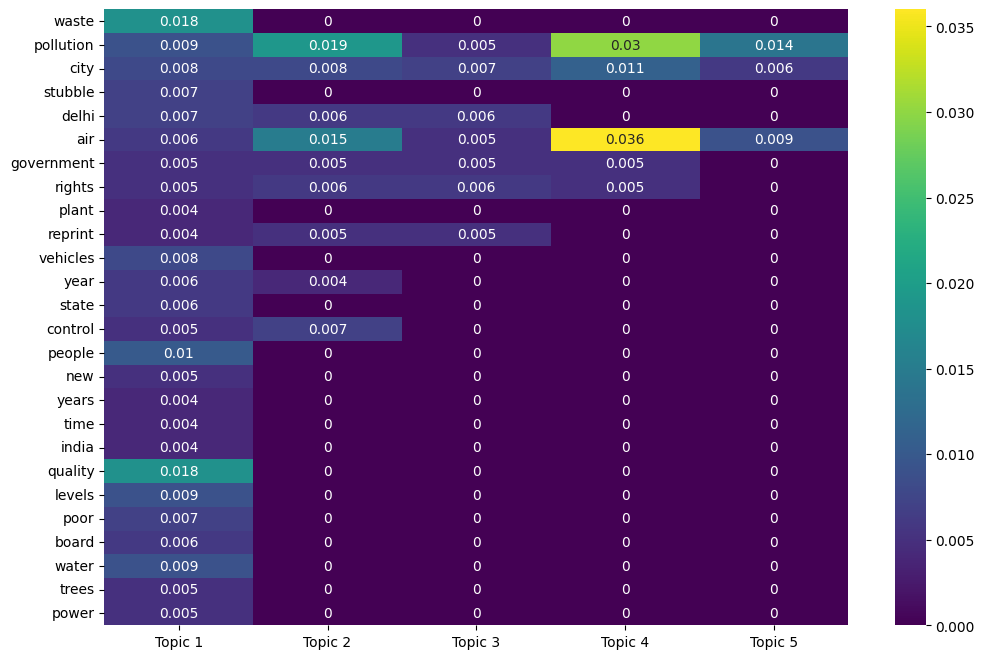

In [ ]:
# Example usage with LDA topics
df_lda = create_topic_word_matrix(lda_model.print_topics(num_words=10))
plot_heatmap(df_lda)

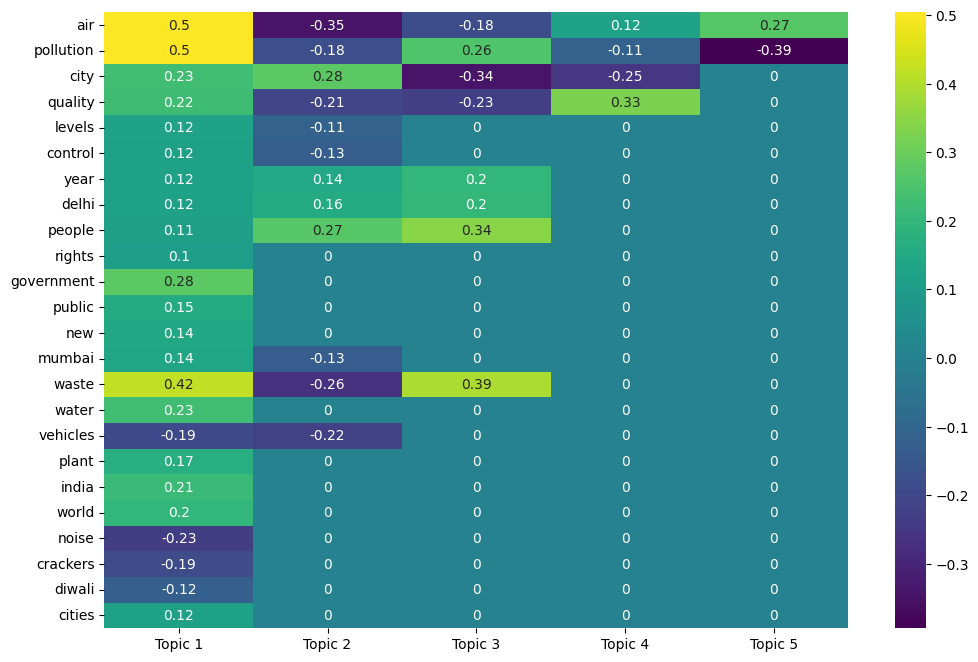

In [ ]:
df_lsi = create_topic_word_matrix(lsi_model.print_topics(num_words=10))
plot_heatmap(df_lsi)

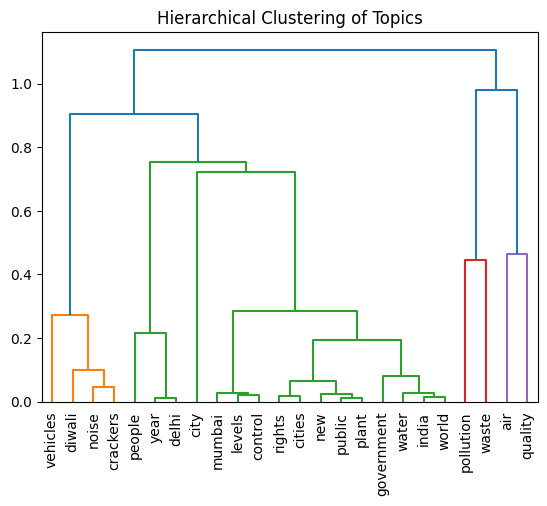

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(df):
    link = linkage(df.T, method='ward')
    dendrogram(link, labels=df.columns, leaf_rotation=90, leaf_font_size=10)
    plt.title('Hierarchical Clustering of Topics')
    plt.show()

# Reuse the DataFrame from heatmap generation
plot_dendrogram(df_lsi)


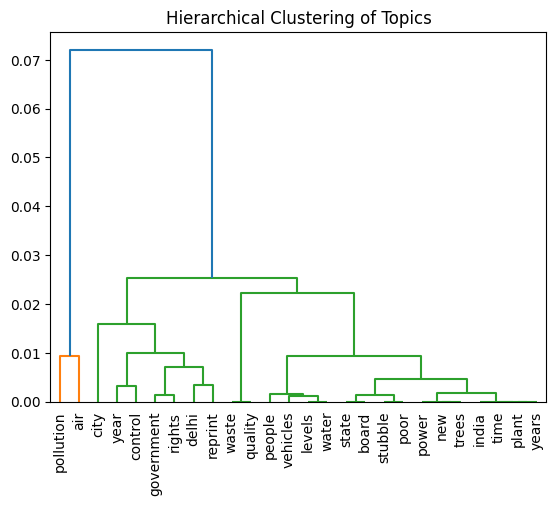

In [ ]:
# Reuse the DataFrame from heatmap generation
plot_dendrogram(df_lda)


In [ ]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_distances

def plot_mds(topic_word_distributions):
    # Calculate the distance matrix from the topic-word distributions
    dist_matrix = cosine_distances(topic_word_distributions)

    # Use MDS to project this distance matrix into a 2-dimensional space
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    embeddings = mds.fit_transform(dist_matrix)

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.scatter(embeddings[:, 0], embeddings[:, 1])
    for i, txt in enumerate(range(embeddings.shape[0])):
        plt.annotate(f'Topic {txt + 1}', (embeddings[i, 0], embeddings[i, 1]))
    plt.title('Inter-Topic Distance Map (MDS)')
    plt.xlabel('MDS Dimension 1')
    plt.ylabel('MDS Dimension 2')
    plt.grid(True)
    plt.show()



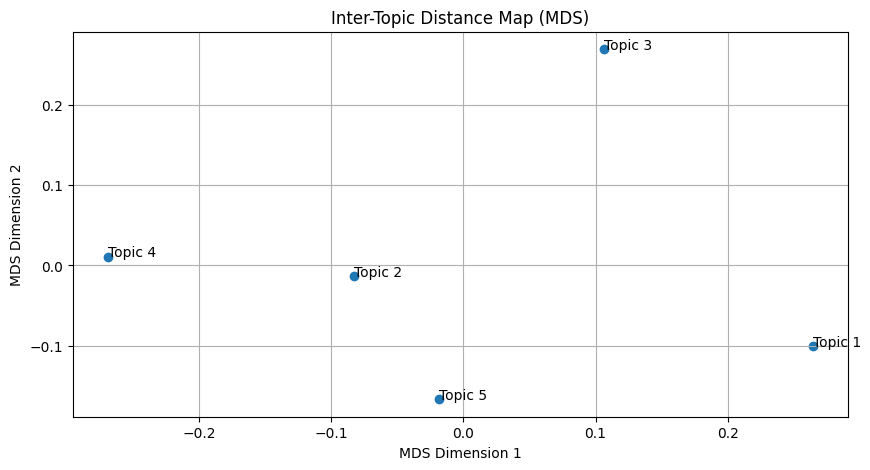

In [ ]:
plot_mds(topic_word_distributions=lda_model.get_topics())


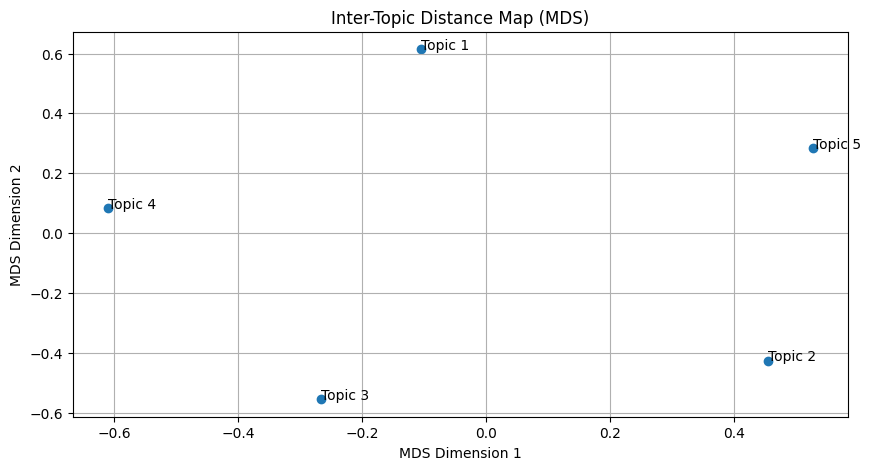

In [ ]:
plot_mds(topic_word_distributions=lsi_model.get_topics())
